# Black Scholes Model Deep Calibration - learning prices

In a first step the required libraries are imported.

In [13]:
# Libraries laden
import numpy as np
from math import log, sqrt, exp
from scipy import stats
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Data generation and preparation

In the next cell a function similar to R's expand grid is defined which is then used to generate the synthetic data. After that some functions to calculate the option price based on the Black-Scholes formula and to calculate the implied volatility are defined. Functions for the option vega and the implied volatility were taken from https://aaronschlegel.me/implied-volatility-functions-python.html.

In [14]:
# Function that equals R's expand_grid
import itertools
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [15]:
# Generate synthetic data
synthetic_data = expand_grid({
    'stock_price': np.arange(40, 61),
    'strike_price':np.arange(20, 90),
    'maturity': np.arange(3/12, 2, step = 1/12),
    'risk_free_rate':np.arange(0.01, 0.06, step = 0.01),
    'sigma': np.arange(0.1, 0.9, step = 0.1)
}
)

In [16]:
# Black-Scholes Modell zur Berechnung der IV
def bs_option_value(S0, K, T, r, sigma):
    'Function to calculate the value of a call option based on the Black-Scholes formula'
    'arguments:'
    'S0: inital stock price'
    'K: strike price'
    'T: maturity'
    'r: risk free rate (constant)'
    'sigma: volatility'
    'returns: option value'
    #calculate d1 and d2
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    d2 = ((np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    option_value = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0)
    return option_value

In [17]:
# Testing the function
bs_option_value(1,2,4,3,5)

0.9999999988919036

In [18]:
# calculate option vega
def option_vega(S0, K, T, r, sigma):
    'takes the same arguments as the function above'
    'returns option vega'
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T)))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

In [19]:
# Testing the function
option_vega(1,2,3,4,5)

1.7320507924724615

In [20]:
# calculate implied volatility
def implied_volatility(S0, K, T, C0, r, sigma):
    'calculates the implied volatility'
    'C0: call price'
    'retunts implied volatility'
    d1 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0) - C0
    
    vega = (1 / np.sqrt(2 * np.pi)) * S0 * np.sqrt(T) * np.exp(-(stats.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    # Warum hier andere Formal fuer vega?
    
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while (abs(xnew - xold) > tolerance):
        xold = xnew
        xnew = (xnew - fx - C0) / vega
        
        return abs(xnew)
# Source for the vega und iv functions: https://aaronschlegel.me/implied-volatility-functions-python.html

In [21]:
# Testing the function
implied_volatility(1,2,3,4,5,6)

8.683118302572918

In [22]:
synthetic_data['black_scholes'] = bs_option_value(synthetic_data['stock_price'], synthetic_data['strike_price'],
                                               synthetic_data['maturity'], synthetic_data['risk_free_rate'],
                                               synthetic_data['sigma'])

In [23]:
# Add some random noise to the real prices to create the option prices
synthetic_data["option_price"] = synthetic_data["black_scholes"] + np.random.normal(1, 0.1)

In [25]:
synthetic_data.tail()

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price
1234795,60,89,1.916667,0.05,0.4,7.034793,8.013349
1234796,60,89,1.916667,0.05,0.5,10.297248,11.275804
1234797,60,89,1.916667,0.05,0.6,13.608121,14.586677
1234798,60,89,1.916667,0.05,0.7,16.897179,17.875735
1234799,60,89,1.916667,0.05,0.8,20.122101,21.100657


In [26]:
# generate train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(synthetic_data, test_size = 0.01,
                                                   random_state = 42)

In [31]:
# Dataframes with Xs and ys
X_train = train.drop(['option_price', 'black_scholes'], axis = 1)
X_test = test.drop(['option_price', 'black_scholes'], axis = 1)
y_train = train['option_price']
y_test = test['option_price']

In [32]:
X_train

,stock_price,strike_price,maturity,risk_free_rate,sigma
483303,48,35,0.833333,0.03,0.8
992823,56,81,1.833333,0.03,0.8
523674,48,83,0.916667,0.05,0.3
456675,47,73,1.333333,0.05,0.4
160003,42,70,1.083333,0.01,0.4
...,...,...,...,...,...
110268,41,81,0.666667,0.04,0.5
259178,44,48,1.166667,0.03,0.3
131932,42,37,0.333333,0.02,0.5
671155,51,48,1.916667,0.05,0.4


In [33]:
X_train.shape

(1222452, 5)

## Model generation

In [34]:
# build the neural net
from keras.layers import Activation
model = tf.keras.models.Sequential([
    #tf.keras.layers.InputLayer(input_shape = (5,)), # Anzahl Features
    tf.keras.layers.Dense(units = 200, activation = 'relu', input_shape = (5,)),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'relu'),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'relu'),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'relu'),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 1, activation = 'linear')
])
model.compile(loss='mse',optimizer='adam')
# Model configuration: The model architecture was chosen based on a literature review (e.g. Liu et al. (2019)).

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________


In [36]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=4) 

# https://blog.paperspace.com/tensorflow-callbacks/

## Model training

In [37]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, batch_size = 1024, epochs = 1000, verbose = 1, callbacks = [callback])


Epoch 1/1000
1075/1075 [==============================] - 18s 16ms/step - loss: 5.2091 - val_loss: 0.9282
Epoch 2/1000
1075/1075 [==============================] - 17s 16ms/step - loss: 0.7996 - val_loss: 0.4469
Epoch 3/1000
1075/1075 [==============================] - 17s 16ms/step - loss: 0.4122 - val_loss: 0.3022
Epoch 4/1000
1075/1075 [==============================] - 17s 16ms/step - loss: 0.2229 - val_loss: 0.1011
Epoch 5/1000
1075/1075 [==============================] - 16s 15ms/step - loss: 0.1442 - val_loss: 0.3218
Epoch 6/1000
1075/1075 [==============================] - 17s 16ms/step - loss: 0.1604 - val_loss: 0.0841
Epoch 7/1000
1075/1075 [==============================] - 17s 16ms/step - loss: 0.1051 - val_loss: 0.2506
Epoch 8/1000
1075/1075 [==============================] - 17s 15ms/step - loss: 0.1106 - val_loss: 0.0187
Epoch 9/1000
1075/1075 [==============================] - 18s 16ms/step - loss: 0.0849 - val_loss: 0.0353
Epoch 10/1000
1075/1075 [=====================

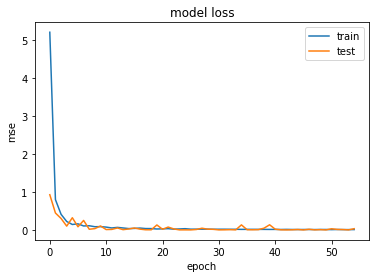

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Model evaluation and predictions on the test set

In [39]:
# Generate predictions on the test set
y_hat = model.predict(X_test)
y_hat = np.squeeze(y_hat)

In [40]:
y_hat = np.array(y_hat, dtype='float')

In [41]:
y_hat

array([26.30708504, 28.50786018, 13.45418072, ..., 30.20541954,
        2.42214274, 40.10568619])

In [58]:
# Defines a function to calculate some performance measures
# Source: https://srdas.github.io/DLBook/DeepLearningWithPython.html#option-pricing
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = np.sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(10,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    return stats

Mean Squared Error:       0.03299288191340152
Root Mean Squared Error:  0.18163942830069005
Mean Absolute Error:      0.15784786937944983
Mean Percent Error:       0.014423576295146373


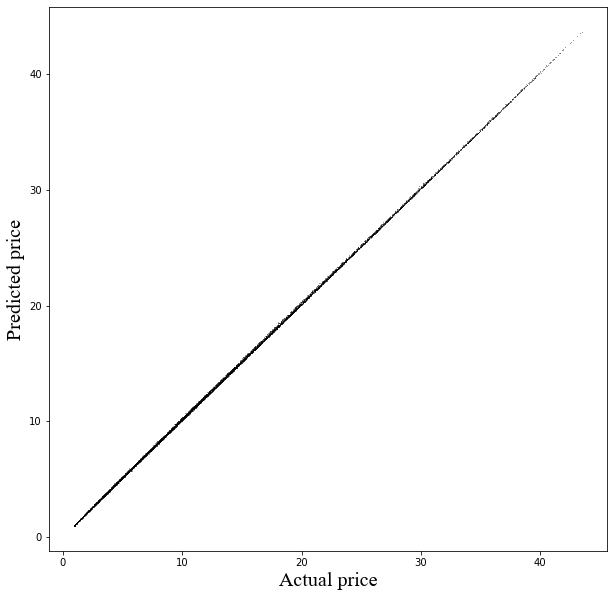

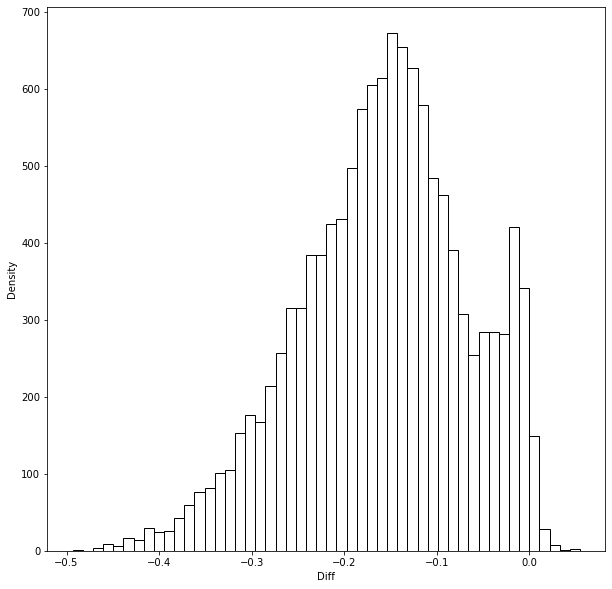

{'diff': 954765    -0.260517
 711377    -0.192785
 1086810   -0.301379
 859684    -0.237743
 1040050   -0.125862
              ...   
 530703    -0.256603
 608920    -0.166504
 591292    -0.184913
 462411    -0.118873
 1120191   -0.241529
 Name: option_price, Length: 12348, dtype: float64,
 'mse': 0.03299288191340152,
 'rmse': 0.18163942830069005,
 'mae': 0.15784786937944983,
 'mpe': 0.014423576295146373}

In [59]:
# Print performance measures and plot actual versus predicted iv
CheckAccuracy(y_test,y_hat)